In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 設定目前程式資料夾路徑(務必自行更改)

In [1]:
folder="/content/drive/MyDrive/解密AI黑盒子分享/"

## import 基礎套件

In [2]:
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as plt_font
twfont1 = plt_font.FontProperties(fname=folder+"字型/kaiu.ttf")

## 載入pytorch相關套件

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader 

## 是否有GPU可以使用

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 讀取資料集檔案


In [7]:
with open(folder+"資料集/Feeling.csv") as f:
  file_list = f.readlines()
print(file_list)

['good,1\n', 'bad,0\n', 'happy,1\n', 'sad,0\n', 'not good,0\n', 'not bad,1\n', 'not happy,0\n', 'not sad,1\n', 'very good,1\n', 'very bad,0\n', 'very happy,1\n', 'very sad,0\n', 'i am happy,1\n', 'this is good,1\n', 'i am bad,0\n', 'this is bad,0\n', 'i am sad,0\n', 'this is sad,0\n', 'i am not happy,0\n', 'this is not good,0\n', 'i am not bad,1\n', 'this is not sad,1\n', 'i am very happy,1\n', 'this is very good,1\n', 'i am very bad,0\n', 'this is very sad,0\n', 'this is very happy,1\n', 'i am good not bad,1\n', 'this is good not bad,1\n', 'i am bad not good,0\n', 'i am good and happy,1\n', 'this is not good and not happy,0\n', 'i am not at all good,0\n', 'i am not at all bad,1\n', 'i am not at all happy,0\n', 'this is not at all sad,1\n', 'this is not at all happy,0\n', 'i am good right now,1\n', 'i am bad right now,0\n', 'this is bad right now,0\n', 'i am sad right now,0\n', 'i was good earlier,1\n', 'i was happy earlier,1\n', 'i was bad earlier,0\n', 'i was sad earlier,0\n', 'i am 

## 分割資料特徵(句子)和分類標示(1是樂觀或0是悲觀)

In [8]:
data=[line.strip().split(",") for line in file_list]
print(data)

[['good', '1'], ['bad', '0'], ['happy', '1'], ['sad', '0'], ['not good', '0'], ['not bad', '1'], ['not happy', '0'], ['not sad', '1'], ['very good', '1'], ['very bad', '0'], ['very happy', '1'], ['very sad', '0'], ['i am happy', '1'], ['this is good', '1'], ['i am bad', '0'], ['this is bad', '0'], ['i am sad', '0'], ['this is sad', '0'], ['i am not happy', '0'], ['this is not good', '0'], ['i am not bad', '1'], ['this is not sad', '1'], ['i am very happy', '1'], ['this is very good', '1'], ['i am very bad', '0'], ['this is very sad', '0'], ['this is very happy', '1'], ['i am good not bad', '1'], ['this is good not bad', '1'], ['i am bad not good', '0'], ['i am good and happy', '1'], ['this is not good and not happy', '0'], ['i am not at all good', '0'], ['i am not at all bad', '1'], ['i am not at all happy', '0'], ['this is not at all sad', '1'], ['this is not at all happy', '0'], ['i am good right now', '1'], ['i am bad right now', '0'], ['this is bad right now', '0'], ['i am sad righ

## 建立所有文本的詞庫

In [9]:
#建立詞庫空列表
worddata=[]
#建立將單字對應到索引的字典資料
word2index={}
#建立將索引對應到單字的字典資料
index2word={}
#用來統計最大長度的語句
maxlen=0
#逐一讀取訓練資料的語句為text
for text,label in data:
  #將語句以空白字元切割成單字word
  textlist=text.split(' ')
  if len(textlist)>maxlen:
    maxlen=len(textlist)
  for word in textlist:
    #如果這個單字不再單字庫內，就新增
    if not word in worddata:
      word2index[word]=len(worddata)
      index2word[len(worddata)]=word
      worddata.append(word)
word_size = len(worddata)
print('單字庫總字數:',word_size)
print('單字庫所有單字:',worddata)
print('最長句子:',maxlen)

單字庫總字數: 18
單字庫所有單字: ['good', 'bad', 'happy', 'sad', 'not', 'very', 'i', 'am', 'this', 'is', 'and', 'at', 'all', 'right', 'now', 'was', 'earlier', 'or']
最長句子: 10


## 定義將語句的單詞轉成one hot encode的函數

In [13]:
def text2vector(text):
  #input用來儲存語句的單字向量
  inputs = []
  #將語句以空白字元切割成單字word
  for word in text.split(' '):
    #如果這個單字在單字庫內，就將單字轉one hot encode放到input中
    if word in worddata:
      one_hot=np.zeros(len(worddata))
      one_hot[word2index[word]] = 1.0
      inputs.append(one_hot)
  #句子太短做padding
  for i in range(len(inputs),maxlen):
    inputs.insert(0,np.zeros(len(worddata)))
  return np.array(inputs)


## 建立DataSet類別

In [14]:
class MyDataset(Dataset):
  def __init__(self,Train=True):
    if Train==True:
      self.data=data[:50]
    else:
      self.data=data[50:]
  def __getitem__(self, index):
    return torch.tensor(text2vector(self.data[index][0])), torch.tensor([int(self.data[index][1])])
  def __len__(self): 
    return len(self.data)

## 實體化訓練和測試DataSet和DataLoader

In [15]:
TrainDS=MyDataset(Train=True)
TestDS=MyDataset(Train=False)
TrainDL=DataLoader(dataset=TrainDS,batch_size=5,shuffle=False)
TestDL=DataLoader(dataset=TrainDS,batch_size=len(TestDS),shuffle=False)

In [17]:
TrainDS[10]

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        dtype=torch.float64), tensor([1]))

## 建立LSTM神經網路類別

In [18]:
class LSTM(nn.Module):
  def __init__(self, InputNode, HiddenNode, LayerNum, OutputNode):
    super(LSTM, self).__init__()
    self.Cell = nn.LSTM(InputNode, HiddenNode, LayerNum, batch_first=True)
    self.fc = nn.Linear(HiddenNode, OutputNode)
  def forward(self, x):
    Cellout, hx = self.Cell(x, None)
    output = torch.sigmoid(self.fc(Cellout[:,-1,:]))
    return output

## 實體化神經網路，指定損失函數和優化器

In [19]:
InputNode=word_size
HiddenNode=64
LayerNum=1
OutputNode=1
Net=LSTM(InputNode, HiddenNode, LayerNum, OutputNode).to(device)
LossFun= torch.nn.BCELoss()
optim = torch.optim.SGD(Net.parameters(), lr=0.1)
Time_Step = 10
Step_L=[]

## 開始訓練神經網路

In [20]:
Net.train()
for epoch in range(500):
  for data,label in TrainDL:
    data= data.reshape(-1,maxlen,InputNode).to(device)
    optim.zero_grad()
    Yh = Net(data.float())
    loss = LossFun(Yh, label.float().to(device))
    Step_L.append(loss.item())
    loss.backward()
    optim.step()
  display.clear_output(wait=True)
  print("回合：",epoch+1,"損失函數",loss.item())

回合： 500 損失函數 9.37411023187451e-05


## 觀察訓練過程中的損失函數Loss變化

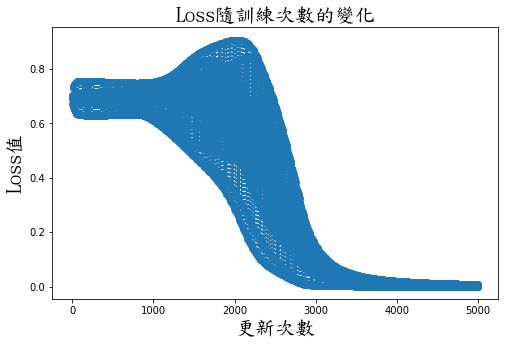

In [21]:
plt.figure(figsize=(8,5))
plt.title("Loss隨訓練次數的變化",fontproperties=twfont1,fontsize=20) 
plt.xlabel("更新次數",fontproperties=twfont1,fontsize=20) 
plt.ylabel("Loss值",fontproperties=twfont1,fontsize=20)
plt.plot(Step_L,":o")
plt.show()

In [22]:
Net.eval()
with torch.no_grad():
  data,label=next(TestDL.__iter__())
  output = Net(data.float())
  data= data.reshape(-1, maxlen, InputNode).to(device)
  TestYh = Net(data.float())
print("驗證資料準確度：",(torch.round(TestYh)==label).sum().item()*100/len(TestDS),"%")

驗證資料準確度： 100.0 %


In [24]:
text=input("輸入文字敘述描述心情:")
data = torch.tensor(text2vector(text))
with torch.no_grad():
  data= data.reshape(-1, maxlen, InputNode).to(device)
  TestYh = Net(data.float())
if torch.round(TestYh)==1:
  print("很好，你很樂觀")
else:
  print("加油，不要太悲觀喔")

輸入文字敘述描述心情:i am not happy
加油，不要太悲觀喔
